# Reservoir computing

Here we try to improve the prediction of model on experimental data by using pre-trained AMNWt. This model is pre-trained on simulated data created by using cobra solver. We use this on two pair of dataset. Fist on e_coli, we use e_coli_core_UB as simulated dataset and iML1515_EXP_UB as experimental dataset. Then on P.putida, we use IJN1463_10_UB as simulated dataset and IJN1463_EXP_UB_Anne.

In [43]:
# E_coli
dataset_file_simulated = "./Dataset/e_coli_core_UB.npz"
objective_simulated=['BIOMASS_Ecoli_core_w_GAM']
dataset_file_experimental = "./Dataset/iML1515_EXP_UB.npz"
objective_experimental=['BIOMASS_Ec_iML1515_core_75p37M']

model_file_simulated = "Models/AMNWt_e_coli_core_UB.keras"

drop_out_rate = 0

batch_size = 7
epochs = 2000

## Load the pre-trained model and simulated dataset information

In [44]:
import tensorflow as tf
from aMNWtModel import AMNWtModel, RNNCell

model_class = AMNWtModel
seed = 10
tf.random.set_seed(seed)


model_simulated = model_class(dataset_file=dataset_file_simulated, 
                   objective=objective_simulated,
                   timestep=4,
                   hidden_dim=50,
                #    epochs=50, 
                   verbose=True,
                #    batch_size=7
                   )


model_simulated.train_test_split(test_size=0.1, random_state=seed)

# Preprocessing
from tools import MaxScaler
scaler= MaxScaler()
model_simulated.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_simulated.preprocessing_for_specific_model()


from tools import custom_loss
AMNWt_model = tf.keras.models.load_model(model_file_simulated, 
                                          custom_objects={"RNNCell":RNNCell,
                                                          "my_mse":custom_loss(model_simulated.S, 
                                                                               model_simulated.P_out,
                                                                               model_simulated.P_in)}
                                          )

print("R2 :", model_simulated.R2(model_simulated.Y_train, AMNWt_model.predict(model_simulated.X_train)))
print("Q2 :", model_simulated.R2(model_simulated.Y_test, AMNWt_model.predict(model_simulated.X_test)))

number of metabolites:  72
filtered measurements size:  1
10.0
R2 : 0.9888228666362848
Q2 : 0.9861056804729627


## Load the experimental data

In [45]:
import tensorflow as tf
from aMNWtModel import AMNWtModel


model_class = AMNWtModel
seed = 10 
# seed = 20
tf.random.set_seed(seed)


print("---------------------------------------- model ----------------------------------------")
model_experimental = model_class(dataset_file=dataset_file_experimental, 
                   objective=objective_experimental,
                   timestep=4,
                #    n_hidden=1, 
                   hidden_dim=50,
                  #  epochs=50, 
                   verbose=True,
                  #  batch_size=7
                   )

# Preprocessing
model_experimental.train_test_split(test_size=0.1, random_state=seed)
from tools import MaxScaler
scaler= MaxScaler()
model_experimental.preprocess(scaler)
print(scaler.max)

# Add tree zero column to the Y
model_experimental.preprocessing_for_specific_model()

---------------------------------------- model ----------------------------------------
number of metabolites:  1080
filtered measurements size:  1
1


## Add a layer to old pre-trained model and fix model weights

In [46]:

from tensorflow.keras import Model, Input, layers

input_size_exp = model_experimental.X.shape[1]
input_size_sim = model_simulated.X.shape[1]


sub_model = AMNWt_model
sub_model.trainable = False
drop_out = layers.Dropout(drop_out_rate, input_shape=(input_size_sim,))
layer = layers.Dense(input_size_sim,activation='relu')

inputs = Input((input_size_exp))
x = layer(drop_out(inputs))
y = sub_model(x)
new_model = Model(inputs=inputs, 
                  outputs=y)
new_model.compile(optimizer='adam',
              loss=custom_loss(model_simulated.S, model_simulated.P_out, model_simulated.P_in),
              metrics=None)

In [47]:
import numpy as np
scaler= MaxScaler()

X = scaler.fit_transform(model_experimental.X)
Y = np.concatenate((model_experimental.Y, np.zeros((len(model_experimental.Y),3))), axis=1)

# Shuffle dataset
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

In [48]:
history = new_model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=0)
R_2 = model_simulated.R2(Y, new_model.predict(X))
print(R_2)

0.6152958264321058


## Using cobra with output of the new_model as input on e_coli (for now)

In [49]:
# V_in is not zero
V_in = layer(X)
V_in[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.       ,  2.2603707,  1.4901307,  1.2036135,  0.       ,
        3.2522714,  1.0129282, 81.763855 ,  0.       ,  0.       ,
       21.085003 ,  0.       ,  0.       ,  0.       ,  0.4716106,
        0.       ,  0.       ,  0.       ,  0.       , 30.770226 ],
      dtype=float32)>

In [50]:
import cobra
from run_cobra import run_cobra

# experimental
cobra_model = cobra.io.read_sbml_model("Dataset/iML1515_EXP_UB.xml")
objective = ["BIOMASS_Ec_iML1515_core_75p37M"]

# simulated
cobra_model = cobra.io.read_sbml_model("Dataset/e_coli_core_UB.xml")
objective = ['BIOMASS_Ecoli_core_w_GAM']

Y_pred = []
for i in range(V_in.shape[0]):

    inf = {r.id: 0 for r in cobra_model.reactions}
    ## Reaction must be linked to e_coli_model
    for j in range(V_in.shape[1]):
        inf[model_simulated.medium[j]] = V_in[i,j]
        result = run_cobra(cobra_model,objective , inf)

    Y_pred.append(result[1])


/home/agiralt/anaconda3/envs/AMN/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [51]:
TRUE = Y[:,0]
PRED = Y_pred

In [53]:
import sklearn
sklearn.metrics.r2_score(TRUE, PRED)

-3.5086795887646236

In [61]:
PRED

[0.09682907704330994,
 0.07537114346496096,
 0.07242725622149128,
 0.08879089703135398,
 0.06824705748690009,
 0.0855741454704246,
 0.08092601562265156,
 0.07644695652246854,
 0.08372901673286827,
 0.07688571655506439,
 0.09540455047247472,
 0.08501204835220887,
 0.07072037178214262,
 0.08448622419568479,
 0.09113549268931746,
 0.07536850541069437,
 0.09477410512623699,
 0.07127605356353407,
 0.09023544041889857,
 0.09320492424783035,
 0.09165996698973387,
 0.08242535770107548,
 0.05919114772964472,
 0.055731080708579274,
 0.091253455612982,
 0.077626828813769,
 0.08255311536539979,
 0.06809001322416659,
 0.0797416845796721,
 0.08245538378540719,
 0.07050537342508531,
 0.09177928355028463,
 0.09277109618720714,
 0.061921832598777565,
 0.07946084490858152,
 0.07391467024419239,
 0.07097327648317157,
 0.08215820685444801,
 0.07753188754504714,
 0.07043251992677048,
 0.08292524588829303,
 0.07210961105745126,
 0.06906833900753719,
 0.08698968087716424,
 0.0784057597389006,
 0.079925437207

In [60]:
TRUE

array([0.07036642, 0.08812777, 0.30990109, 0.15756536, 0.36883461,
       0.19897683, 0.22768201, 0.33618463, 0.20772926, 0.19995003,
       0.15491189, 0.13398423, 0.34018671, 0.16647387, 0.19236413,
       0.26806339, 0.23150512, 0.29771937, 0.13505459, 0.27124001,
       0.09241834, 0.26096546, 0.33546881, 0.07198777, 0.10823699,
       0.16958847, 0.24690668, 0.38366267, 0.21547613, 0.30221964,
       0.33156464, 0.16739003, 0.19488304, 0.39292909, 0.19885259,
       0.29190893, 0.36209367, 0.16876883, 0.22754484, 0.33509878,
       0.2020666 , 0.30498805, 0.26057603, 0.20953583, 0.17060508,
       0.16546936, 0.41345674, 0.2246795 , 0.25305511, 0.24051223,
       0.19361131, 0.30265454, 0.27081596, 0.23701745, 0.25491721,
       0.12092238, 0.33610419, 0.10738262, 0.1319873 , 0.27311799,
       0.11354416, 0.16118613, 0.13401356, 0.25608325, 0.39489686,
       0.26244328, 0.20408691, 0.32553523, 0.18870321, 0.35197431,
       0.29636434, 0.36538323, 0.27056665, 0.24511303, 0.22554

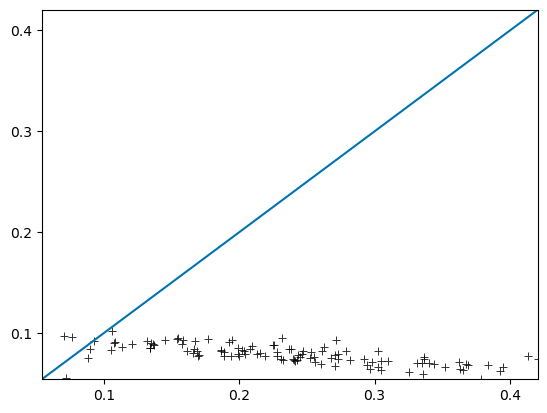

In [66]:
from tools import plot_regression
plot_regression(PRED, TRUE, "", "","")